<a href="https://colab.research.google.com/github/agustinivandinocco-python/pythonpracticateoria/blob/main/Colab/clase_08_notebook_complementario_algos_geneticos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Planteo de Idea a Backtestear

Que tal si...

Buscamos cada XX tiempo (trimestral) el __portafolio de 5 activos__ que optimice riesgo/retorno (Markowitz), y vamos "roleando" la idea cada XX tiempo

Es decir con la cartera optima del trimestre 0 invertimos para el trimestre 1, y asi..



Que tal si...

En lugar de hacer "EL" mejor portafolio o "LA" mejor relacion riesgo/beneficio, usamos una __cartera de 10 portafolios__



In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn-v0_8')
#plt.style.use('seaborn')
mpl.rcParams['axes.facecolor'] = 'w'
plt.rcParams['figure.dpi'] = 120
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7


# Optimizacion Sharpe via Scipy

In [ ]:
import yfinance as yf
import numpy as np
from scipy import optimize

df = yf.download(['MSFT','AAPL','KO'], start='2010-01-01', end='2022-07-01')['Close']
df = df.loc[~(df==0).any(axis=1)]
ret_log = np.log((df/df.shift(1)).dropna())

[*********************100%***********************]  3 of 3 completed


In [ ]:
ret_log

Ticker,AAPL,KO,MSFT
Date,,,
2010-01-05,0.001728,-0.012171,0.000323
2010-01-06,-0.016034,-0.000354,-0.006156
2010-01-07,-0.001850,-0.002489,-0.010454
2010-01-08,0.006626,-0.018682,0.006873
2010-01-11,-0.008861,0.020105,-0.012802
...,...,...,...
2022-06-24,0.024222,0.018572,0.033580
2022-06-27,0.000000,-0.002064,-0.010552
2022-06-28,-0.030243,-0.010065,-0.032264


In [ ]:
def sharpe_neg(weights):
    FREE_RISK = 0.025
    global ret_log
    weights = np.array(weights)
    ret = np.sum(ret_log.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T,np.dot(ret_log.cov()*252,weights)))
    sr = (ret-FREE_RISK)/vol
    return -sr

In [ ]:
def check_sum(weights):
    return np.sum(weights) -1

In [ ]:
cons = ({'type':'eq','fun':check_sum})
bounds = [(0.05,1)] * len(ret_log.columns)
init_guess = [0.1] * len(ret_log.columns)

opt_results = optimize.minimize(sharpe_neg, init_guess, bounds=bounds, constraints=cons)
opt_results

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.8099107678728467
       x: [ 5.766e-01  1.185e-01  3.049e-01]
     nit: 8
     jac: [-1.096e-01 -1.096e-01 -1.094e-01]
    nfev: 32
    njev: 8

In [ ]:
(opt_results['x'] * 100).round(2)

array([57.66, 11.85, 30.49])

# Ejemplo de aplicacion - Markowitz

## Repaso básico concepto Sharpe Ratio

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np

FREE_RISK = 0.025
df = yf.download(['MSFT','AAPL','KO'], start='2010-01-01', end='2022-07-01')['Close']
df = df.loc[~(df==0).any(axis=1)]
retornos = np.log((df/df.shift(1)).dropna())

[*********************100%***********************]  3 of 3 completed


In [ ]:
datosTickers = []
for ticker in retornos.columns:
    d = {}
    d['ticker'] = ticker
    d['retorno'] = retornos[ticker].mean() * 252
    d['volatilidad'] = retornos[ticker].std() * (252**0.5)
    d['sharpe'] = (d['retorno']-FREE_RISK) / d['volatilidad']
    datosTickers.append(d)


datosTickers = pd.DataFrame(datosTickers).set_index('ticker')
datosTickers

,retorno,volatilidad,sharpe
ticker,,,
AAPL,0.243724,0.284316,0.769300
KO,0.094472,0.176052,0.394609
MSFT,0.190661,0.255564,0.648216


## Simulamos varias composiciones

In [ ]:
q = 10_000
retornos = np.log((df/df.shift(1)).dropna())
carteras = []

for i in range(q):
    print (f'Simulando portafolio N° {i+1} de {q}     ', end='\r')
    pond = np.array(np.random.random(len(df.columns)))
    pond = pond/np.sum(pond)
    r={}
    r['retorno'] = np.sum( (retornos.mean() * pond * 252))
    r['volatilidad'] = np.sqrt(np.dot(pond, np.dot(retornos.cov()*252, pond)))
    r['sharpe'] = (r['retorno']-FREE_RISK) / r['volatilidad']
    r['pesos'] = pond.round(4)
    carteras.append(r)

carteras = pd.DataFrame(carteras)
carteras

,retorno,volatilidad,sharpe,pesos
0,0.162374,0.182297,0.753572,"[0.25, 0.432, 0.318]"
1,0.204038,0.227521,0.786907,"[0.7121, 0.2538, 0.0341]"
2,0.204835,0.225532,0.797382,"[0.6715, 0.2231, 0.1053]"
3,0.134389,0.175462,0.623436,"[0.0111, 0.5912, 0.3977]"
4,0.169107,0.190455,0.756648,"[0.2275, 0.3496, 0.4229]"
...,...,...,...,...
9995,0.176377,0.195237,0.775352,"[0.2866, 0.3066, 0.4067]"
9996,0.148072,0.172636,0.712898,"[0.2473, 0.5792, 0.1735]"
9997,0.162536,0.181882,0.756185,"[0.2659, 0.4391, 0.295]"
9998,0.155813,0.180789,0.723568,"[0.1648, 0.4532, 0.3821]"


## Extraigo la mejor combinación

In [ ]:
optimo = carteras.loc[carteras['sharpe'].idxmax()]
mejor_port = carteras.iloc[carteras['sharpe'].idxmax()]['pesos']

datosTickers['ponderacion_optima'] = mejor_port
datosTickers

,retorno,volatilidad,sharpe,ponderacion_optima
ticker,,,,
AAPL,0.243724,0.284316,0.769300,0.5798
KO,0.094472,0.176052,0.394609,0.1189
MSFT,0.190661,0.255564,0.648216,0.3013


In [ ]:
carteras.sharpe.max()

0.8099062193607188

In [ ]:
datosTickers.ponderacion_optima

,ponderacion_optima
ticker,
AAPL,0.5798
KO,0.1189
MSFT,0.3013


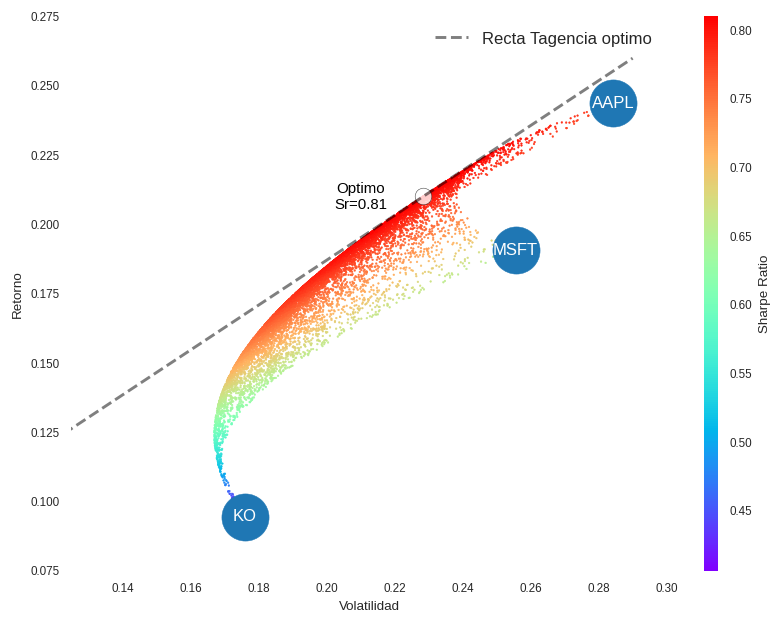

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,6))
chart = ax.scatter(carteras.volatilidad, carteras.retorno, c=carteras.sharpe, s=1, cmap='rainbow')

fig.colorbar(chart, label='Sharpe Ratio', aspect=40)
ax.set_xlabel('Volatilidad')
ax.set_ylabel('Retorno')

optimo_txt = f'Optimo\nSr={carteras.sharpe.max():.2f}'
ax.scatter(optimo.volatilidad, optimo.retorno, c='white', alpha=0.8, edgecolors='black', s=100)
ax.text(optimo.volatilidad*0.92, optimo.retorno, optimo_txt, fontsize=9, c='k', ha='center', va='center')

for ticker in df.columns:
    vol = datosTickers.loc[ticker,'volatilidad']
    ret = datosTickers.loc[ticker,'retorno']
    ax.scatter(vol, ret,  c='tab:blue', s=800)
    ax.text(vol, ret, ticker, c='w', ha='center', va='center')


ax.set_xlim(0.125,.3)
ax.set_ylim(0.075,.275)

m = (optimo.retorno - FREE_RISK) /  optimo.volatilidad
tg = [m * x + FREE_RISK for x in [i/100 for i in range(30)]]
ax.plot([i/100 for i in range(30)], tg, 'k--', alpha=0.5, label='Recta Tagencia optimo')
ax.legend()
ax.grid(alpha=0.3)

## Markowitz - 500 activos

Buscamos el portafolio optimo entre muchos portafolios posibles

## Dificultades

* Elegir combinacion ideal entre millones de combinaciones
* Una vez sampleadas las combinaciones:
    * A- Elegir ponderaciones al azar de millones de combinaciones
    * B- Optimizar por descenso del gradiente las millones de combinaciones

## Bajamos Data

In [ ]:
import yfinance as yf, numpy as np, pandas as pd, random, tqdm

# Esto es porque a veces al conectarse local rebota el request por no estar cifrado
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
# Obtengo el listado de tickers del sp500
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500_tickers = list(sp500.Symbol)
sp500_tickers = [e.replace('.','-') for e in sp500_tickers]

sp500_tickers[:10]

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']

In [ ]:
pd.options.display.max_columns = 8

In [ ]:
%%time

# Obtengo todos los historicos
data_sp500 = yf.download(sp500_tickers, start='2018-01-01', auto_adjust=True)['Close']

# Para evitar tickers con poco historial
conteo = pd.DataFrame(data_sp500.count(), columns=['Q'])
sp500_tickers = list(conteo.loc[conteo.Q > 500].index)

data_sp500

[*********************100%***********************]  503 of 503 completed


CPU times: user 31.4 s, sys: 2.45 s, total: 33.8 s
Wall time: 1min 12s


Ticker,A,AAPL,ABBV,ABNB,...,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,
2018-01-02,64.044167,40.426823,71.013657,NaN,...,71.530045,113.763306,103.709999,67.852081
2018-01-03,65.673691,40.419792,72.124931,NaN,...,71.468697,114.551949,105.769997,68.164085
2018-01-04,65.181053,40.607529,71.713608,NaN,...,72.196274,114.386879,107.860001,68.570580
2018-01-05,66.223206,41.069866,72.961998,NaN,...,72.617020,115.523949,109.540001,69.355270
2018-01-08,66.365280,40.917320,71.792961,NaN,...,72.739746,115.744041,110.629997,70.187248
...,...,...,...,...,...,...,...,...,...
2025-05-19,113.440002,208.779999,185.710007,136.600006,...,149.649994,95.769997,297.820007,163.940002
2025-05-20,113.480003,206.860001,184.850006,132.130005,...,149.029999,95.349998,296.970001,163.649994
2025-05-21,108.910004,202.089996,181.800003,127.519997,...,146.429993,92.739998,287.920013,161.440002


## Ponderaciones

### Uniform

Esta dist me permite no solo generar una muestra aleatoria de ponderaciones que sumen 1, con restricciones (min y max), si no que me permite pasarle como argumento un vector "w" para sesgarle el peso de determinados componentes, no lo voy a hacer en estos ejemplos pero les dejo el modelo, en lugar de pasar el vector "w" como un vector de unos, le paso un vector sesgado y listo

<Axes: >

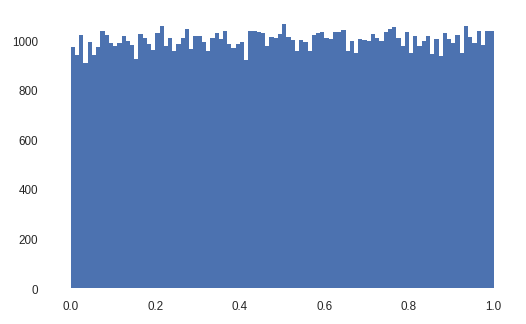

In [ ]:
from scipy import stats
import pandas as pd

d_uni = stats.uniform(0,1).rvs(10**5)
pd.Series(d_uni).hist(bins=100, figsize=(5,3))

In [ ]:
# Ejemplo de pesos para cartera de 5 assets con uniforme

weights = stats.uniform(0,1).rvs(5)
weights = weights/sum(weights)
weights

array([0.30307394, 0.07609053, 0.25157758, 0.35392912, 0.01532883])

### Distribución Beta

Funcion de distribucion:

$$ \Large f(x) = \quad \frac{x^{\alpha-1}(1-x)^{\beta-1}} {\mathrm {B} (\alpha,\beta)}\! $$

Para $x$ tal que $0 < x < 1$, y una función beta $B(\alpha, \beta)$ definida para $\alpha, \beta > 0$

$$ {\Large \mathrm {B} (\alpha ,\beta )={\frac {\Gamma (\alpha )\Gamma (\beta )}{\Gamma (\alpha +\beta )}}}  $$

Dada una __funcion gamma__:
$$ \Large \Gamma_{(\alpha)} = \int_0^{\infty} \frac{x^{(\alpha-1)}}{e^x} dx $$

Con la propiedad:
$$ \Large \Gamma (n)=(n-1)! $$

In [ ]:
from scipy import special
from math import factorial

def getFactGamma(x):
    if isinstance(x, int):
        print(f'El factorial de {x} es {factorial(x)}')
        return factorial(x)
    if isinstance(x, float):
        print(f'El gamma de {x} es {special.gamma(x):.2f}')
        return special.gamma(x)

getFactGamma(5), getFactGamma(6.0)

El factorial de 5 es 120
El gamma de 6.0 es 120.00


(120, np.float64(120.0))

<img src='https://upload.wikimedia.org/wikipedia/commons/d/d2/PDF_Beta_Distribution_Animation.gif'
    width=300, style='float:left'>

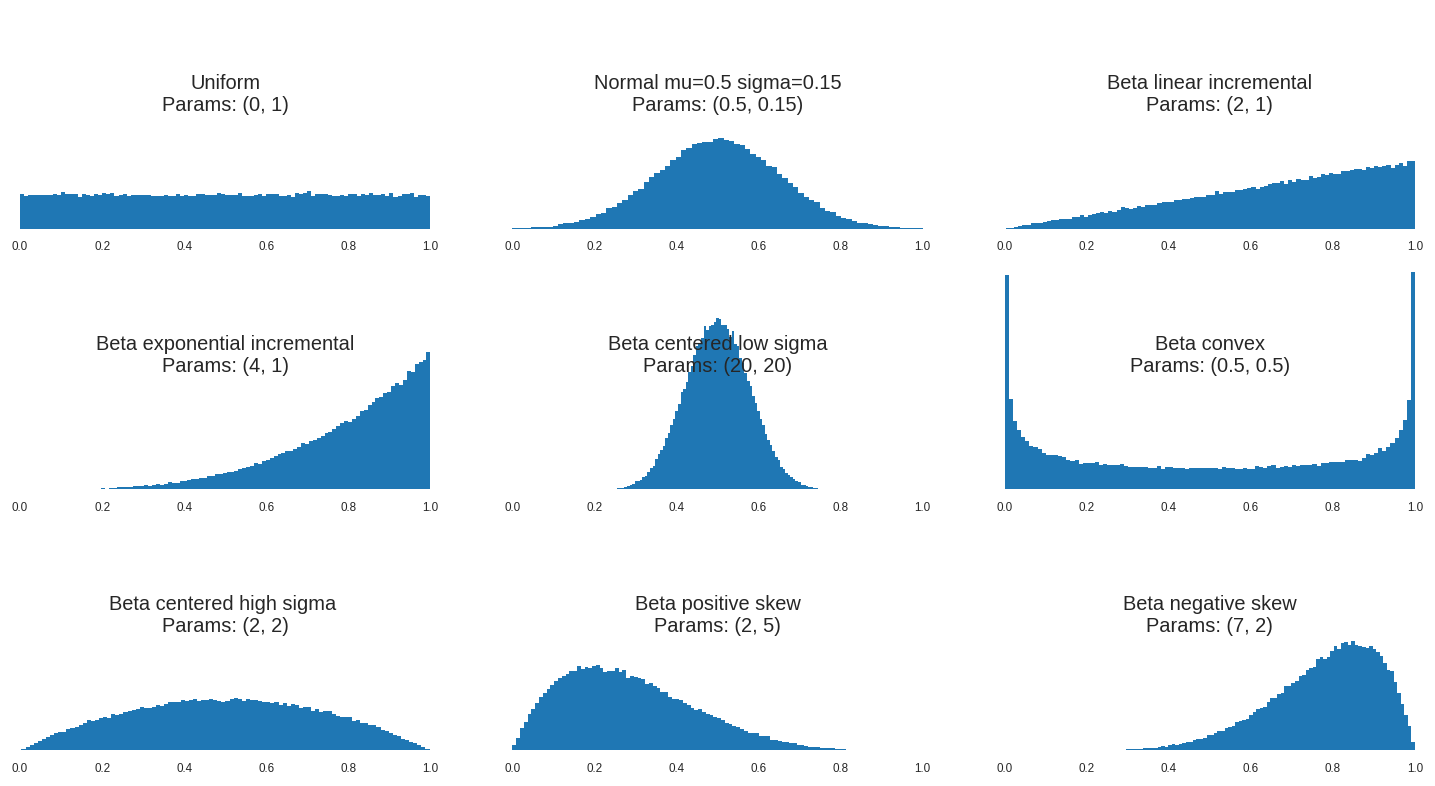

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

columns = 3
fig, ax = plt.subplots(ncols=columns, nrows=3, figsize=(15,8))
sample = 10**5

params = [(0,1), (0.5, 0.15), (2,1), (4,1), (20,20), (0.5,0.5), (2,2), (2,5), (7,2)]
distributions = {'Uniform':pd.DataFrame(np.random.uniform(0, 1, size=sample)),
        'Normal mu=0.5 sigma=0.15' : pd.DataFrame(np.random.normal(0.5, 0.15, size=sample)),
        'Beta linear incremental' : pd.DataFrame(np.random.beta(2, 1, size=sample)),
        'Beta exponential incremental' : pd.DataFrame(np.random.beta(4, 1, size=sample)),
        'Beta centered low sigma' : pd.DataFrame(np.random.beta(20, 20, size=sample)),
        'Beta convex' : pd.DataFrame(np.random.beta(0.5, 0.5, size=sample)),
        'Beta centered high sigma ' : pd.DataFrame(np.random.beta(2, 2, size=sample)),
        'Beta positive skew' : pd.DataFrame(np.random.beta(2, 5, size=sample)),
        'Beta negative skew' : pd.DataFrame(np.random.beta(7, 2, size=sample)),
        }

fr_max = 0
for i, (title, distribution) in enumerate(distributions.items()):
  row, col = i // columns, i % columns
  y_, x_, chart = ax[row][col].hist(distribution, bins=100,color='tab:blue', density=True)
  ax[row][col].set_title(title+'\nParams: '+str(params[i]), y=0.5)
  ax[row][col].set_xlim(0,1)
  fr_max = max(fr_max, y_.max())
  ax[row][col].spines['top'].set_visible(False)
  ax[row][col].spines['right'].set_visible(False)
  ax[row][col].spines['left'].set_visible(False)
  ax[row][col].set_yticks([])

for i, (title, distribution) in enumerate(distributions.items()):
  row, col = i // columns, i % columns
  ax[row][col].set_ylim(0, fr_max)

plt.subplots_adjust(hspace=0.2, wspace=0.2)

<Axes: >

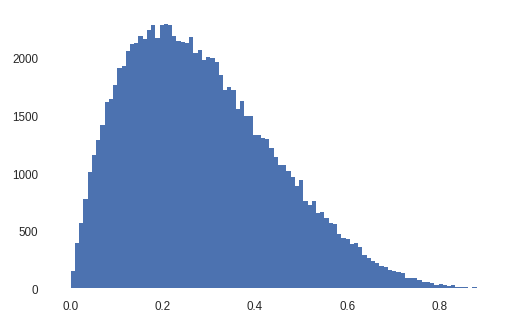

In [ ]:
d_beta = stats.beta(2, 5).rvs(10**5)
pd.Series(d_beta).hist(bins=100, figsize=(5,3))

In [ ]:
# Ejemplo de pesos para cartera de 5 assets con beta
# Ver dificultad para generar carteras con por ejemplo 50% 30% 10% 5% 5%

weights = stats.beta(4,1).rvs(5)
weights = weights/sum(weights)
weights

array([0.17072246, 0.20855065, 0.21398435, 0.2023717 , 0.20437084])

### Beta Generalizada (Dirichlet)

Definimos la funcion de distribucion $ f\left({X;\alpha}\right)$
<br>Fijense que es la misma formula que la distribucion $\beta$ pero generalizada para "K" parametros
$$  {\Large f\left(x_{1},\ldots ,x_{K};\alpha _{1},\ldots ,\alpha _{K}\right)={\frac {1}{\mathrm {B} ({\boldsymbol {\alpha }})}}\prod _{i=1}^{K}x_{i}^{\alpha _{i}-1}} $$

dado un vector $ { x_{1},\ldots ,x_{K}} \quad $  donde $ \quad  {x_{i}\in (0,1)}\quad  \land  \quad  {\Large \sum _{i=1}^{K}x_{i}=1}  $
<br>Esta ultima condicion es clave, porque nos saca la necesidad de "normalizar" los pesos

Siendo la funcion $\mathrm {B}({\boldsymbol {\alpha }}) $:

$$ {\large \mathrm {B} ({\boldsymbol {\alpha }})={\frac {\prod \limits _{i=1}^{K}\Gamma (\alpha _{i})}{\Gamma \left(\sum \limits _{i=1}^{K}\alpha _{i}\right)}},\qquad {\boldsymbol {\alpha }}=(\alpha _{1},\ldots ,\alpha _{K}).} $$

## Generar un vector de weights aleatorio

### Uniforme

In [ ]:
assets = 5
dist = stats.uniform(0,1).rvs(assets)
dist / dist.sum()

array([0.01680917, 0.14369186, 0.22636767, 0.36402952, 0.24910178])

### Beta

In [ ]:
assets = 5
dist = stats.beta(1,20).rvs(assets)
dist / dist.sum()

array([0.02075992, 0.57278157, 0.19463568, 0.05052672, 0.16129611])

In [ ]:
# Ejercicio ¿como construirían un portafolio con
    # 3 activos con mucha mas proba de pesos mayores a 20%
    # 2 activos con mucha mas proba de pesos menores al 10%

In [ ]:
dist1 = stats.beta(3,1).rvs(3)
dist2 = stats.beta(1,10).rvs(2)

dist = np.concatenate([dist1, dist2])
dist / dist.sum()

array([0.26390257, 0.35615487, 0.25028754, 0.08190909, 0.04774593])

### Dirichlet

In [ ]:
np.random.seed(0)
np.random.dirichlet([1,1,1,1,1],1)

array([[0.18451732, 0.29117779, 0.21404211, 0.18250647, 0.12775631]])

In [ ]:
# Genero un vector de pesos para nstocks=5

nstocks = 5

np.random.seed(0)
np.random.dirichlet(np.ones(nstocks),1)

array([[0.18451732, 0.29117779, 0.21404211, 0.18250647, 0.12775631]])

Varianza:

    * A menores valores de los componentes del vector, mayor varianza
    * A mayores valores de los componentes, menor varianza

Distribucion:

    * El valor relativo de cada posicion del vector respecto al resto es proporcional al mu de ese componente

In [ ]:
np.random.seed(0)
np.random.dirichlet([.2]*5,1)

array([[0.02377958, 0.03800271, 0.0065184 , 0.00766308, 0.92403623]])

In [ ]:
np.set_printoptions(suppress=True) # suprime la notacion cientifica en el display de numpy
np.random.dirichlet([30,30,30,5,5],10).round(3)

array([[0.265, 0.333, 0.279, 0.047, 0.076],
       [0.306, 0.191, 0.357, 0.123, 0.023],
       [0.347, 0.344, 0.225, 0.014, 0.07 ],
       [0.403, 0.267, 0.248, 0.04 , 0.042],
       [0.254, 0.334, 0.293, 0.065, 0.054],
       [0.352, 0.289, 0.304, 0.034, 0.02 ],
       [0.22 , 0.328, 0.344, 0.05 , 0.057],
       [0.279, 0.299, 0.32 , 0.028, 0.074],
       [0.326, 0.223, 0.369, 0.043, 0.039],
       [0.327, 0.281, 0.299, 0.044, 0.05 ]])

In [ ]:
# Calculemos la varianza para diferentes valores de 10k muestras

x = 1
np.random.dirichlet([x]*5,10000).std()

np.float64(0.16412376399241183)

In [ ]:
x = 3
np.random.dirichlet([x]*5,10000).std()

np.float64(0.09973949599227622)

In [ ]:
x = 0.5
np.random.dirichlet([x]*5,10000).std()

np.float64(0.21340078935409082)

CPU times: user 372 ms, sys: 0 ns, total: 372 ms
Wall time: 374 ms


<Axes: >

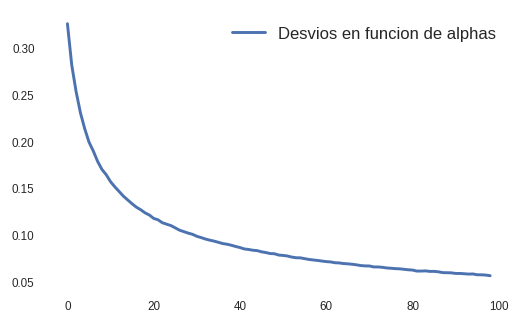

In [ ]:
%%time
desvios = []
for i in range(1,100):
    x = i/10
    desvios.append(np.random.dirichlet([x]*5,10000).std())

pd.DataFrame(desvios, columns=['Desvios en funcion de alphas']).plot(figsize=(5,3))

### Agregar restricciones a los weights

Se soluciona generando una cantidad X de vectores y luego un filtro por las restricciones que me asegure una cantidad Y tal que Y>0 y Y<=X

en el ejemplo tomamos X=1000 vectores originales
<br>Usamos una uniforme de sigma=0.16
<br>y obtenemos Y=583 que cumplen las restriccciones pedidas

In [ ]:
p_min, p_max = 0.01, 0.5
n_stocks = 5

np.random.seed(0)
ponds = np.random.dirichlet(np.ones(n_stocks),10**3)
oks = [vector for vector in ponds if np.all((vector > p_min) & (vector < p_max))]

len(ponds), len(oks)

(1000, 583)

## Que tantas combinaciones habria que probar?

Recordemos que queria armar 10 portafolios optimos para cualquier combinacion de 5 assets del SP500

Combinaciones de "n" elementos tomados de a "k"

$$ \Large C(n, k) = \binom{n}{k} = \frac{n!}{k!(n-k)!} $$

In [ ]:
import math

def comb(n, k):
    return int(math.factorial(n) / (math.factorial(k) * math.factorial(n-k)))

n = 500
k = 3

comb(n, k)

20708500

In [ ]:
for i in range(3,10):
    print(f'Para {i} activos de {n}, hay: {comb(n,i)//10**6} millones de combinaciones')

Para 3 activos de 500, hay: 20 millones de combinaciones
Para 4 activos de 500, hay: 2573 millones de combinaciones
Para 5 activos de 500, hay: 255244 millones de combinaciones
Para 6 activos de 500, hay: 21057686 millones de combinaciones
Para 7 activos de 500, hay: 1486071034 millones de combinaciones
Para 8 activos de 500, hay: 91579127515 millones de combinaciones
Para 9 activos de 500, hay: 5006325637513 millones de combinaciones


## ¿Por que no podemos elegir los mojores activos y despues combinarlos?

El problema que es toda optimizacion de portafolio necesita la metriz de covarianzas para optimizar pesos

## ¿Por que no usar descenso del gradiente para elegir el mejor portafolio?

Nosotros vamos a querer para cada periodo:

* Los mejores 10 portafolios (no solo el mejor)
* De por ejemplo 5 activos

## ¿Solucion?

Vamos a aplicar __montecarlo para samplear al mismo tiempo de optimizar ponderaciones__

¿Vamos a samplear las 255.244 millones de combinaciones?
<br> __NO__

¿como vamos a randomizar las ponderaciones para cada sampleo al azar?
<br>Vamos a usar una __funcion de variable continua especifica__

¿como vamos hacer para procesar en tiempo lineal esto?
<br>Vamos a usar un __algoritmo genetico__


## Funcion para elegir buenos candidatos

In [ ]:
random.sample(sp500_tickers, 5)

['CNC', 'CRL', 'PCG', 'LUV', 'CZR']

In [ ]:
import sys

def simular(data, tickers, q, p_min=0.01, p_max=0.99, w=[5,3,2]):
    n_stocks = len(w)
    datos = []
    with tqdm.tqdm(total=q, file=sys.stdout) as pbar:
        for i in range(q):
            pbar.update()

            muestra = data[random.sample(tickers, n_stocks)]

            # Restriccion de minimo y maximo
            ponds = np.random.dirichlet(w,100)
            pond = np.array([p for p in ponds if (p.min()>p_min) & (p.max()<p_max)][0])

            # If para evitar activos sin dataFeed
            if len(retornos):
                r={}
                r['activos'] = list(muestra.columns)
                r['pesos'] = pond.round(3)
                r['retorno'] = np.sum( (muestra.mean() * pond * 252))
                r['volatilidad'] = np.sqrt(np.dot(pond, np.dot(muestra.cov()*252, pond)))
                r['sharpe'] = round(r['retorno'] / r['volatilidad'],3)
                datos.append(r)

    df = pd.DataFrame(datos).sort_values('sharpe', ascending=False)

    return df

In [ ]:
%%time
pd.options.display.width = 1000

ret_log = np.log(data_sp500/data_sp500.shift(1))

portfolios = simular(data=ret_log, tickers=sp500_tickers, q=20000, w=[5,3,2])

100%|██████████| 20000/20000 [00:53<00:00, 372.98it/s]
CPU times: user 51.2 s, sys: 409 ms, total: 51.6 s
Wall time: 53.8 s


In [ ]:
print('\n',portfolios.head(10))


                  activos                  pesos   retorno  volatilidad  sharpe
11094   [COST, CEG, COR]  [0.342, 0.226, 0.432]  0.290419     0.213747   1.359
4598   [ORLY, CEG, LULU]  [0.514, 0.253, 0.232]  0.313370     0.246815   1.270
3610     [CEG, STE, ADP]  [0.444, 0.273, 0.284]  0.350080     0.276804   1.265
5455     [WMT, CEG, XEL]   [0.478, 0.33, 0.192]  0.290664     0.229933   1.264
17063  [CEG, CSCO, CARR]  [0.265, 0.166, 0.569]  0.377655     0.298950   1.263
3164   [FICO, CEG, TSCO]  [0.519, 0.342, 0.139]  0.397157     0.314344   1.263
13250   [FICO, CEG, CCL]  [0.436, 0.528, 0.036]  0.452510     0.358601   1.262
10626       [CEG, V, EA]   [0.637, 0.34, 0.023]  0.435747     0.349858   1.245
17738     [CEG, IPG, KO]  [0.808, 0.045, 0.147]  0.499296     0.408274   1.223
1443     [CEG, MCK, COO]  [0.832, 0.074, 0.094]  0.517359     0.423875   1.221


<br><hr>__Recuerden esto:__

* Tardamos 21 segundos
* El mejor sharpe que encontramos fue de 1.28

<hr><br>

In [ ]:
# Buscamos los mejores 100 portafolios de 20k

top = portfolios.iloc[ : 100]
top.activos.apply(pd.Series).stack().reset_index(drop=True)

,0
0,COST
1,CEG
2,COR
3,ORLY
4,CEG
...,...
295,EVRG
296,CEG
297,LLY
298,AFL


In [ ]:
# Armamos la lista de los tickers de esos 100 portafolios

top = portfolios.iloc[ : 100]
lista_tickers = list(top.activos.apply(pd.Series).stack())
len(lista_tickers)

300

In [ ]:
# Contabilizamos frecuencias de esos assets

np.unique(lista_tickers, return_counts=True)

(array(['ACGL', 'ADP', 'AEP', 'AFL', 'AJG', 'AME', 'ANET', 'AON', 'APH',
        'APTV', 'ARE', 'ATO', 'AVB', 'AVGO', 'AXON', 'AZO', 'BK', 'BKNG',
        'BR', 'BRK-B', 'BSX', 'CARR', 'CB', 'CBRE', 'CCL', 'CEG', 'CHRW',
        'CI', 'CMG', 'CMS', 'COIN', 'COO', 'COR', 'COST', 'CPRT', 'CSCO',
        'CTVA', 'CVX', 'DECK', 'DGX', 'DPZ', 'EA', 'ECL', 'EVRG', 'EXE',
        'FAST', 'FDS', 'FDX', 'FE', 'FFIV', 'FICO', 'GDDY', 'GE', 'GEN',
        'GILD', 'GL', 'GPC', 'GRMN', 'GWW', 'HII', 'HSY', 'HUBB', 'HWM',
        'IDXX', 'INCY', 'IPG', 'IRM', 'JBL', 'JKHY', 'JNJ', 'JNPR', 'K',
        'KEYS', 'KLAC', 'KMB', 'KO', 'LLY', 'LNT', 'LOW', 'LULU', 'MCK',
        'MKC', 'MKTX', 'MMC', 'MOH', 'MPC', 'MRK', 'MSFT', 'MSI', 'NDAQ',
        'NOW', 'NTAP', 'NUE', 'NVDA', 'NWSA', 'ODFL', 'ORLY', 'PANW',
        'PAYC', 'PEP', 'PFE', 'PFG', 'PG', 'PGR', 'PLTR', 'PM', 'PNR',
        'PSX', 'PTC', 'PWR', 'PYPL', 'RL', 'ROK', 'ROST', 'RSG', 'SBAC',
        'SHW', 'SJM', 'SNA', 'SO', 'STE', 'SYK', 'T'

In [ ]:
# Armamos "Tabla de posiciones" de assets mas repetidos

freq = pd.DataFrame(np.unique(lista_tickers, return_counts=True)).T
freq.columns=['Ticker','Frecuencia']
freq.sort_values('Frecuencia', ascending=False).head(10)

,Ticker,Frecuencia
25,CEG,52
33,COST,11
21,CARR,11
76,LLY,9
103,PGR,5
44,EXE,5
96,ORLY,5
104,PLTR,5
14,AXON,4
4,AJG,4


<br><hr>
¿Que se les ocurre para mejorar la idea anterior?
<hr><br>

# Algoritmo Genético

Optimmizamos las iteraciones para encontrar un sub-optimo mas rapido

In [ ]:
%%time
q_inicial = 600
lista_tickers = sp500_tickers
ret_log = np.log(data_sp500/data_sp500.shift(1))

portfolios = simular(data=ret_log, tickers=lista_tickers, q=q_inicial, w=[5,3,2])

best = pd.DataFrame()
for i in range(8):
    qsim = int(q_inicial/(i+2))  # decaimiento
    qtop = qsim // 3  # criterio de evolucion o de seleccion

    top = portfolios.iloc[ : qtop]
    lista_tickers = list(np.array(top.activos.apply(pd.Series).stack()))
    portfolios = simular(data=ret_log, tickers=lista_tickers, q=qsim, w=[5,3,2])
    best = pd.concat([best,portfolios.iloc[:10]])

100%|██████████| 66/66 [00:00<00:00, 442.46it/s]
CPU times: user 4.98 s, sys: 35.9 ms, total: 5.01 s
Wall time: 5.17 s


In [ ]:
print('Mejores\n',best.sort_values('sharpe', ascending=False).head(10))

Mejores
              activos                  pesos   retorno  volatilidad  sharpe
54   [CEG, LLY, PGR]     [0.34, 0.24, 0.42]  0.379167     0.246513   1.538
65  [PGR, CEG, CARR]  [0.435, 0.295, 0.269]  0.379334     0.249201   1.522
66  [CEG, ORLY, PGR]   [0.348, 0.321, 0.33]  0.363458     0.238768   1.522
9   [AJG, CARR, CEG]  [0.499, 0.184, 0.316]  0.376668     0.247524   1.522
17  [CEG, ORLY, LLY]  [0.292, 0.479, 0.229]  0.355203     0.234855   1.512
80  [CARR, CEG, PGR]  [0.295, 0.362, 0.342]  0.405766     0.268391   1.512
18  [ORLY, CEG, PGR]  [0.333, 0.271, 0.396]  0.335907     0.222178   1.512
7   [CEG, PGR, ORLY]   [0.37, 0.428, 0.202]  0.372634     0.246973   1.509
3   [AJG, CEG, ORLY]   [0.507, 0.303, 0.19]  0.348701     0.231918   1.504
8   [COST, PGR, CEG]   [0.447, 0.29, 0.263]  0.336297     0.223758   1.503


<br><hr>
Notar las mejoras:

    * Tardamos la decima parte del tiempo
    * Obtuvimos un sharpe ratio al menos un 30% mas alto
<hr><br>

# Implementacion del algoritmo genetico en "n" procesos

## Rolling trimestral del proceso

### Bajamos Data mas antigua

In [ ]:
%%time

pd.options.display.max_columns = 6
data_sp500 = yf.download(sp500_tickers, start='2000-01-01')['Close']
data_sp500.to_csv('nombre_archivo.csv') # guardo el csv

[*********************100%***********************]  499 of 499 completed


CPU times: user 1min 17s, sys: 3.36 s, total: 1min 20s
Wall time: 2min 6s


### Guardamos la data

In [ ]:
import pickle

# Guardamos el dataframe pero en un archivo serializado
with open('yahoo_sp500_20yr.dat', 'wb') as file:
    pickle.dump(data_sp500, file)

In [ ]:
%%time

# Recuperacion del archivo serializado
with open('yahoo_sp500_20yr.dat', 'rb') as file:
    data_sp500 = pickle.load(file)

CPU times: user 12 ms, sys: 7 ms, total: 19 ms
Wall time: 18.8 ms


### Fragmentamos la data

In [ ]:
time_index = pd.date_range(start='2000-01-01', end='2025-06-30', freq='6M')
time_index

DatetimeIndex(['2000-01-31', '2000-07-31', '2001-01-31', '2001-07-31', '2002-01-31', '2002-07-31', '2003-01-31', '2003-07-31', '2004-01-31', '2004-07-31', '2005-01-31', '2005-07-31', '2006-01-31', '2006-07-31', '2007-01-31', '2007-07-31', '2008-01-31', '2008-07-31', '2009-01-31', '2009-07-31', '2010-01-31', '2010-07-31', '2011-01-31', '2011-07-31', '2012-01-31', '2012-07-31', '2013-01-31', '2013-07-31', '2014-01-31', '2014-07-31', '2015-01-31', '2015-07-31', '2016-01-31', '2016-07-31', '2017-01-31', '2017-07-31', '2018-01-31', '2018-07-31', '2019-01-31', '2019-07-31', '2020-01-31', '2020-07-31', '2021-01-31', '2021-07-31', '2022-01-31', '2022-07-31', '2023-01-31', '2023-07-31', '2024-01-31', '2024-07-31', '2025-01-31'], dtype='datetime64[ns]', freq='6ME')

In [ ]:
# armo dos vectores "desde" y "hasta" de cada rango
time_index_from = list(time_index[:-1])
time_index_to = list(time_index[1:])

In [ ]:
# Meto los datos de retornos (payoff) de los assets en cada dataframe (1 por cada rango)
dfs = []
rets_log = np.log(data_sp500/data_sp500.shift(1))
for i in range (len(time_index_from)):
    df = rets_log.loc[(rets_log.index >= time_index_from[i]) & (rets_log.index <= time_index_to[i])].copy()
    df.dropna(axis=1, thresh=15, inplace=True) # thresh es la cantidad minima de datos por batch
    dfs.append(df)

In [ ]:
len(dfs)

50

### Encapsulamos implementacion para optimizar

In [ ]:
def top10(ret_log, lista_tickers, q_inicial=1000, rondas=10, w=np.ones(6)):
    portfolios = simular(ret_log, lista_tickers, q_inicial, w=w, p_min=0.01, p_max=0.99)
    best = pd.DataFrame()
    for i in range(rondas):
        qsim = int(q_inicial/(i+2))
        qtop = qsim//3

        top = portfolios.iloc[ : qtop]
        lista_tickers = list(np.array(top.activos.apply(pd.Series).stack()))
        portfolios = simular(ret_log, lista_tickers, qsim, w=w, p_min=0.01, p_max=0.99)
        best = pd.concat([best,portfolios.iloc[:10]])

    top10 = best.sort_values('sharpe', ascending=False).head(10)
    return top10

### Corremos optimizacion rollenado en la cantidad de periodos que definimos

In [ ]:
from IPython.display import clear_output

In [ ]:
%%time

tops = []
for i, df in enumerate(dfs):
    clear_output(wait=True)
    print('Proceso N°',i+1,'de',len(dfs))
    print('Desde',time_index_from[i],'Hasta',time_index_to[i],'\n')
    top = top10(df, list(df.columns), q_inicial=600, rondas=5, w=[5, 3, 1, 0.5, 0.5])
    tops.append(top.iloc[:10])

Proceso N° 50 de 50
Desde 2024-07-31 00:00:00 Hasta 2025-01-31 00:00:00 

100%|██████████| 100/100 [00:00<00:00, 446.83it/s]
CPU times: user 2min 41s, sys: 1.2 s, total: 2min 42s
Wall time: 2min 45s


<br><br><br><br><br><br><br><br><br>

In [ ]:
# Tenemos para los meses/trimetres/semanas/etc el top10 de portafolios simulados (segun markowitz)
tops[0]

,activos,pesos,retorno,volatilidad,sharpe
55,"[CRL, LH, ISRG, MHK, DGX]","[0.415, 0.393, 0.153, 0.026, 0.013]",3.124845,0.422874,7.390
71,"[ESS, PLD, CAH, ISRG, ISRG]","[0.566, 0.283, 0.012, 0.022, 0.117]",1.413926,0.193704,7.299
35,"[MET, ISRG, CRL, LLY, SJM]","[0.541, 0.289, 0.042, 0.081, 0.048]",2.490638,0.348161,7.154
117,"[LLY, LH, CRL, VRTX, EW]","[0.345, 0.281, 0.304, 0.015, 0.054]",1.958064,0.274114,7.143
21,"[LLY, CRL, LH, ISRG, AON]","[0.234, 0.25, 0.444, 0.04, 0.032]",2.224227,0.312026,7.128
108,"[CRL, LH, BLK, DGX, VRTX]","[0.516, 0.171, 0.237, 0.012, 0.064]",2.454834,0.350676,7.000
60,"[LH, ISRG, AIG, LH, CRL]","[0.443, 0.282, 0.113, 0.011, 0.15]",3.220839,0.464888,6.928
66,"[LH, ISRG, CRL, BKR, CRL]","[0.589, 0.171, 0.05, 0.04, 0.149]",2.969895,0.429633,6.913
17,"[CNP, LH, DGX, CNP, CRL]","[0.422, 0.196, 0.089, 0.035, 0.258]",1.833251,0.269443,6.804
93,"[ISRG, MET, AJG, EQR, DGX]","[0.391, 0.473, 0.045, 0.025, 0.067]",3.048235,0.452238,6.740


In [ ]:
activos, pesos = [], []
for i in range(10):
    #aca adentro para los 10 portafolios, meto los meses/trimetres/semanas/etc en cada uno
    activos.append([df.iloc[i].activos for df in tops])
    pesos.append([df.iloc[i].pesos for df in tops])

In [ ]:
resumen = pd.DataFrame()

for top_nro in range(10):
    # para cada uno de los 10 portafolios...
    lista_rendimientos = []

    for i in range(1,len(dfs)):
        # recorro los meses/trimetres/semanas/etc...
        # y obvio calculo el rendimiento del trimestre pero con los activos seleccionados del trimestre anterior

        filtro_fecha = data_sp500.loc[(data_sp500.index >= time_index_from[i]) & (data_sp500.index <= time_index_to[i])]
        filtro_activos = filtro_fecha[activos[top_nro][i-1]].dropna()
        r = filtro_activos.pct_change()
        w = pesos[top_nro][i-1]
        fechas = pd.to_datetime(filtro_activos.index)
        lista_rendimientos.append(pd.Series(np.dot(r, w), index=fechas).dropna())

    rendimientos = pd.concat(lista_rendimientos)
    resumen['Test_'+str(top_nro)] = (rendimientos+1).cumprod()

resumen

,Test_0,Test_1,Test_2,Test_3,Test_4,Test_5,Test_6,Test_7,Test_8,Test_9
Date,,,,,,,,,,
2000-08-01,0.985073,0.997605,0.981202,1.009677,1.010480,0.983854,0.992490,1.005430,1.001855,0.976738
2000-08-02,0.974596,1.008143,0.968931,1.004304,1.006052,0.973590,0.979784,0.997512,1.005961,0.960150
2000-08-03,1.008686,1.017144,0.962607,1.031646,1.028466,1.014545,0.998356,1.014915,1.036452,0.956329
2000-08-04,1.017539,1.010039,0.958826,1.040602,1.044629,1.024284,1.012574,1.036491,1.049560,0.952281
2000-08-07,1.054462,0.996750,0.997233,1.071148,1.068596,1.073014,1.012238,1.048261,1.103908,0.979234
...,...,...,...,...,...,...,...,...,...,...
2025-01-27,86.652995,133.951364,72.191816,76.504056,82.095059,74.065566,32.532481,113.675260,156.509302,97.567455
2025-01-28,86.221642,133.159159,72.588019,77.217755,82.011148,72.197815,32.041409,112.741855,153.419418,94.954506
2025-01-29,86.398230,132.602890,72.970379,77.372348,82.139024,72.415196,32.087369,113.046410,154.538324,95.923749


### Guardamos resultados estrategia

In [ ]:
with open('resumen.dat', 'wb') as file:
    pickle.dump(resumen, file)

with open('resumen.dat', 'rb') as file:
    resumen = pickle.load(file)

### Ploteamos

<Axes: xlabel='Date'>

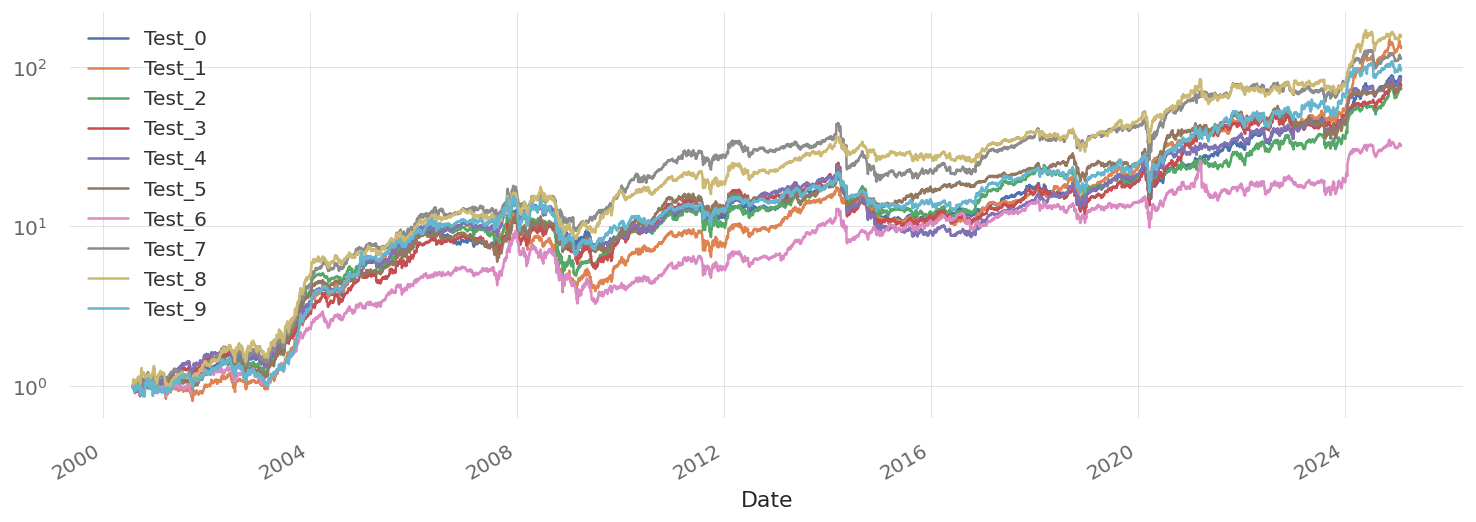

In [ ]:
resumen.plot(figsize=(15,5), logy=True)

In [ ]:
inicio = list(resumen.index)[0].isoformat()[:10]
spy = yf.download('SPY', start=inicio, auto_adjust=True)
spy['pctChange'] = spy.Close.pct_change()
spy['rendimiento_acum'] = (spy.pctChange+1).cumprod()

[*********************100%***********************]  1 of 1 completed


[]

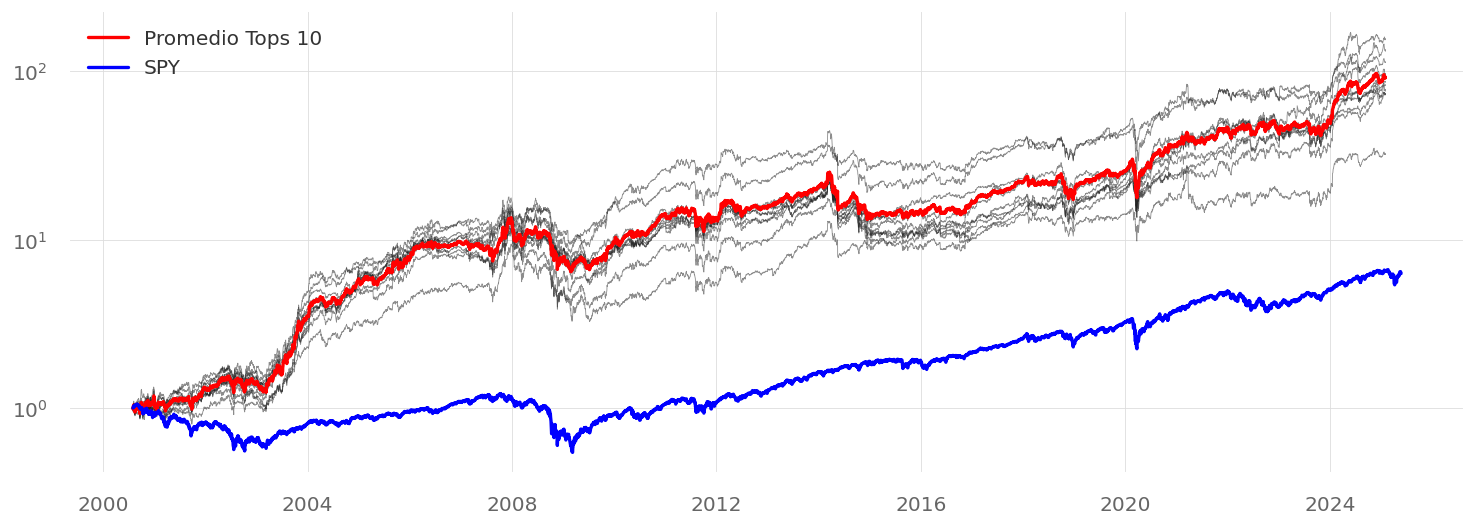

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,5))

for columna in resumen.columns:
    ax.plot(resumen[columna], 'k', alpha=0.5, lw=0.5)
    ax.set_yscale('log')

ax.plot(resumen.iloc[:,:-1].mean(axis=1), 'red', lw=2, label='Promedio Tops 10')
ax.plot(spy['rendimiento_acum'], 'blue', lw=2, label='SPY')

ax.legend()
ax.plot()

<Axes: xlabel='Date'>

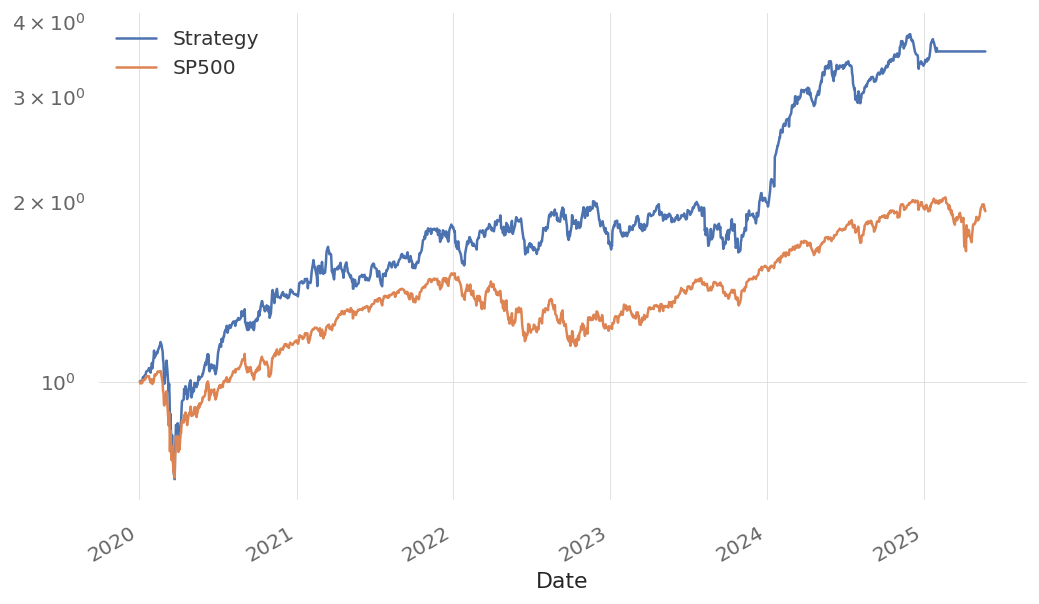

In [ ]:
# Sugerencia, probar diferentes periodos cercanos para ver que no haya incidido tanto el Survivorship bias
fecha_inicio = '2020-01-01'
st = resumen.mean(axis=1).loc[resumen.index>fecha_inicio]
st = st/st.iloc[0]
bench = spy.loc[spy.index>fecha_inicio].pctChange
bench = bench.add(1).cumprod()
bench = bench / bench.iloc[0]
fram_date = pd.concat([st, bench], axis=1).interpolate()
fram_date.columns = ['Strategy','SP500']
fram_date.plot(logy=True)

In [ ]:
resumen

,Test_0,Test_1,Test_2,Test_3,Test_4,Test_5,Test_6,Test_7,Test_8,Test_9
Date,,,,,,,,,,
2000-08-01,0.985073,0.997605,0.981202,1.009677,1.010480,0.983854,0.992490,1.005430,1.001855,0.976738
2000-08-02,0.974596,1.008143,0.968931,1.004304,1.006052,0.973590,0.979784,0.997512,1.005961,0.960150
2000-08-03,1.008686,1.017144,0.962607,1.031646,1.028466,1.014545,0.998356,1.014915,1.036452,0.956329
2000-08-04,1.017539,1.010039,0.958826,1.040602,1.044629,1.024284,1.012574,1.036491,1.049560,0.952281
2000-08-07,1.054462,0.996750,0.997233,1.071148,1.068596,1.073014,1.012238,1.048261,1.103908,0.979234
...,...,...,...,...,...,...,...,...,...,...
2025-01-27,86.652995,133.951364,72.191816,76.504056,82.095059,74.065566,32.532481,113.675260,156.509302,97.567455
2025-01-28,86.221642,133.159159,72.588019,77.217755,82.011148,72.197815,32.041409,112.741855,153.419418,94.954506
2025-01-29,86.398230,132.602890,72.970379,77.372348,82.139024,72.415196,32.087369,113.046410,154.538324,95.923749


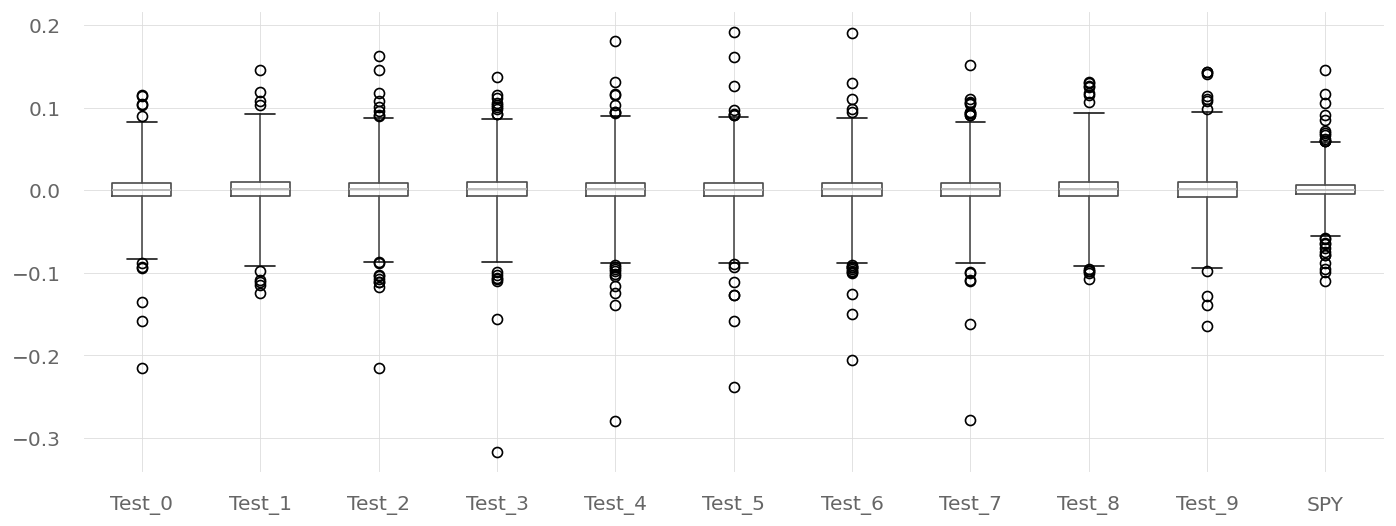

In [ ]:
# Veo robustez o portabilidad
pd.plotting.boxplot_frame(pd.concat([resumen, spy_base1], axis=1).pct_change(), whis=5, figsize=(14,5))
plt.show()

## Reporting Final

In [ ]:
estrategia_rb = resumen.pct_change().mean(axis=1).add(1).cumprod()   # Con rebalanceo
estrategia = resumen.iloc[:,:-1].mean(axis=1)  # Sin rebalanceo

# Armo estrategia mas conservadora
free_risk = pd.DataFrame(index=estrategia.index)
free_risk['usa'] = 0.0001
estrategia_5050 = estrategia.pct_change()*0.5 + free_risk['usa']*0.5

# Defino un benchMark
benchmark = spy['rendimiento_acum']

In [ ]:
!pip install QuantStats -q

In [ ]:
# !pip install QuantStats
import quantstats as qs
qs.extend_pandas()

In [ ]:
qs.reports.metrics(estrategia.pct_change(), benchmark.pct_change(), mode='full')

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2000-08-02   2000-08-02
End Period                 2025-01-31   2025-01-31
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          549.87%      9,118.63%
CAGR﹪                     5.41%        13.59%

Sharpe                     0.49         0.86
Prob. Sharpe Ratio         99.27%       100.0%
Smart Sharpe               0.49         0.85
Sortino                    0.7          1.23
Smart Sortino              0.69         1.22
Sortino/√2                 0.49         0.87
Smart Sortino/√2           0.49         0.86
Omega                      1.17         1.17

Max Drawdown               -55.19%      -52.23%
Longest DD Days            2241         1966
Volatility (ann.)          19.25%       25.34%
R^2                        0.41         0.41
Information Ratio          0.04         0.04
Calmar         

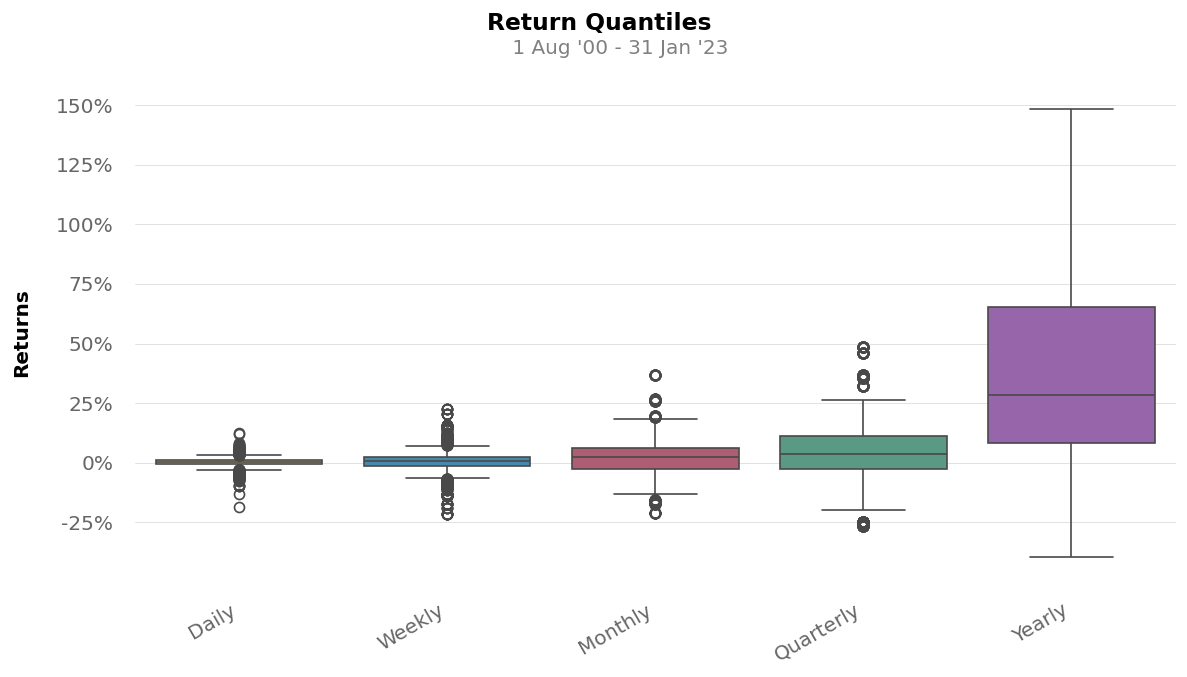

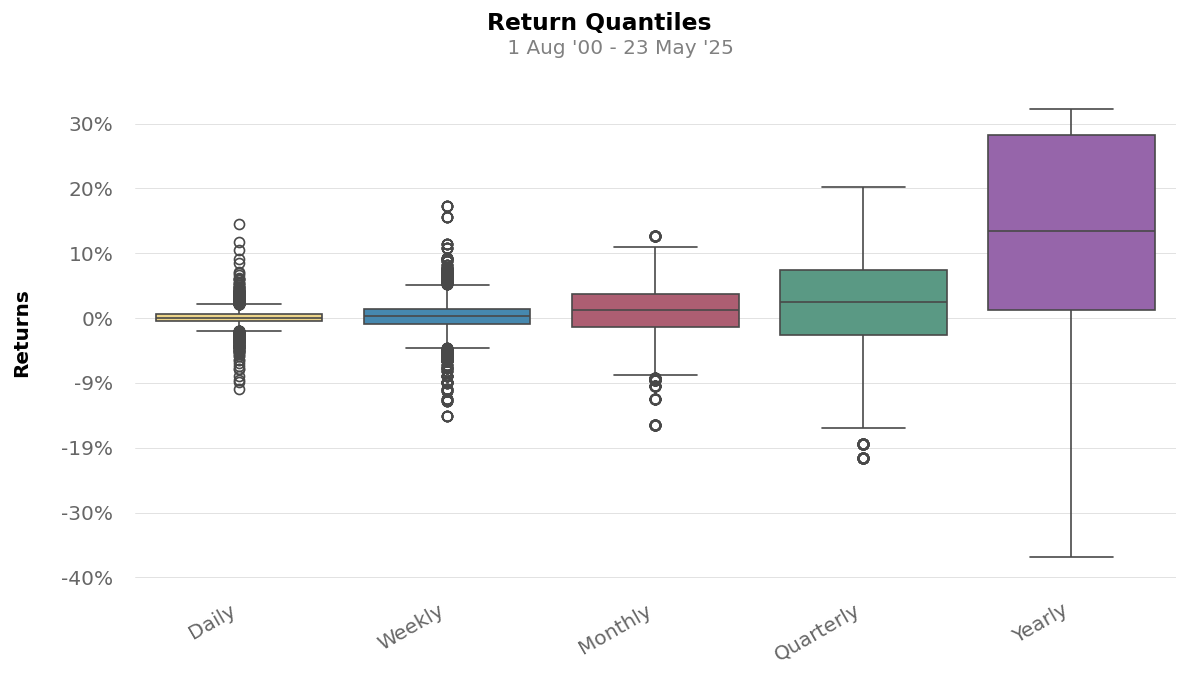

In [ ]:
qs.plots.distribution(estrategia)
qs.plots.distribution(benchmark.pct_change())

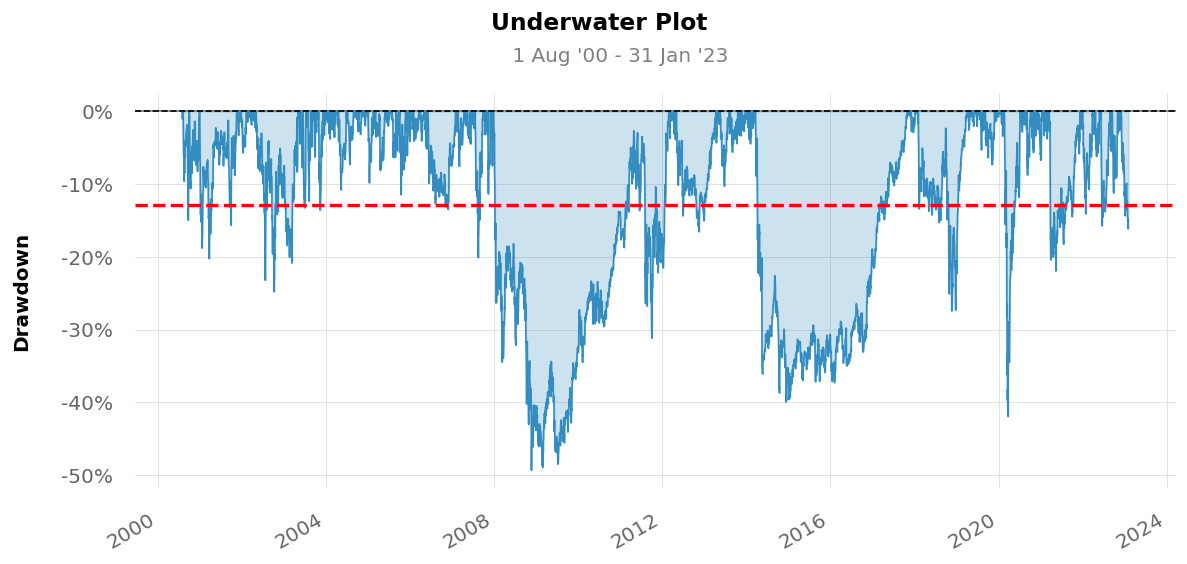

In [ ]:
qs.plots.drawdown(estrategia)

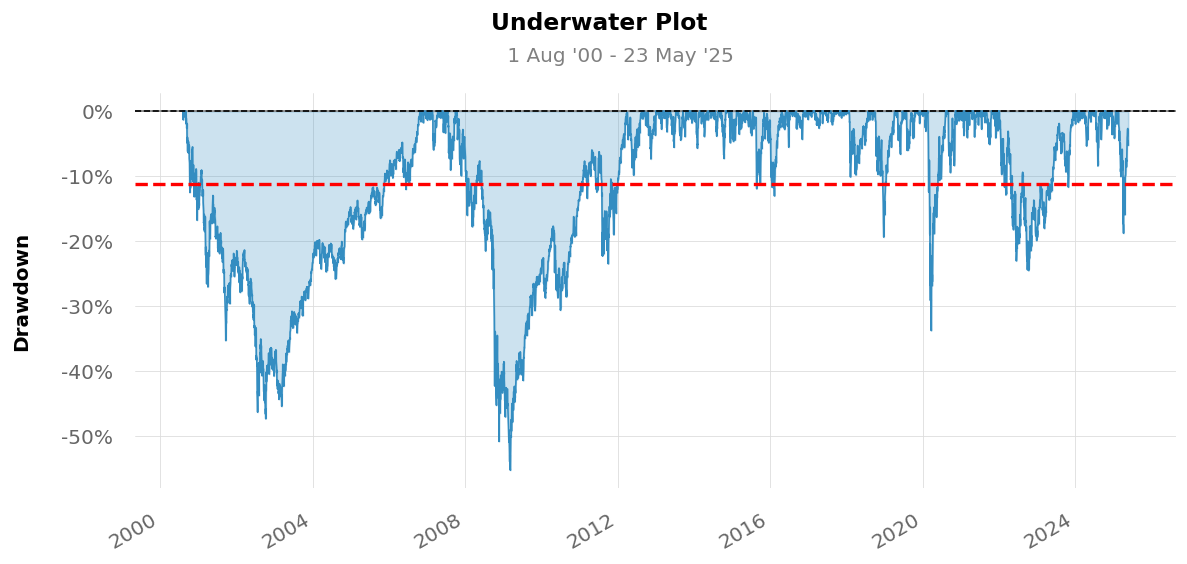

In [ ]:
qs.plots.drawdown(benchmark.pct_change())

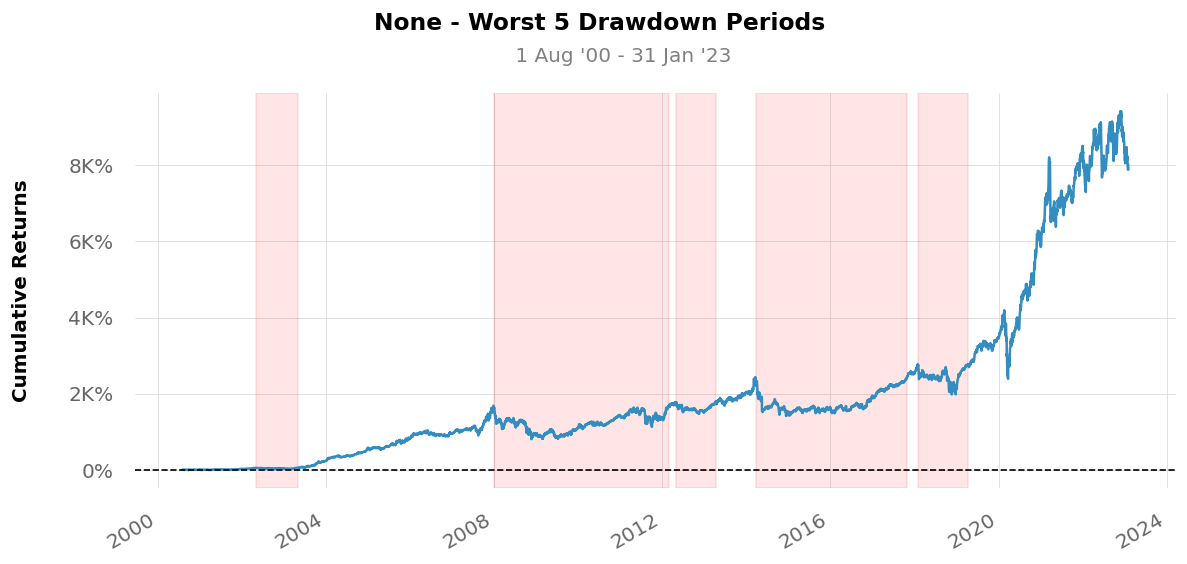

In [ ]:
qs.plots.drawdowns_periods(estrategia)

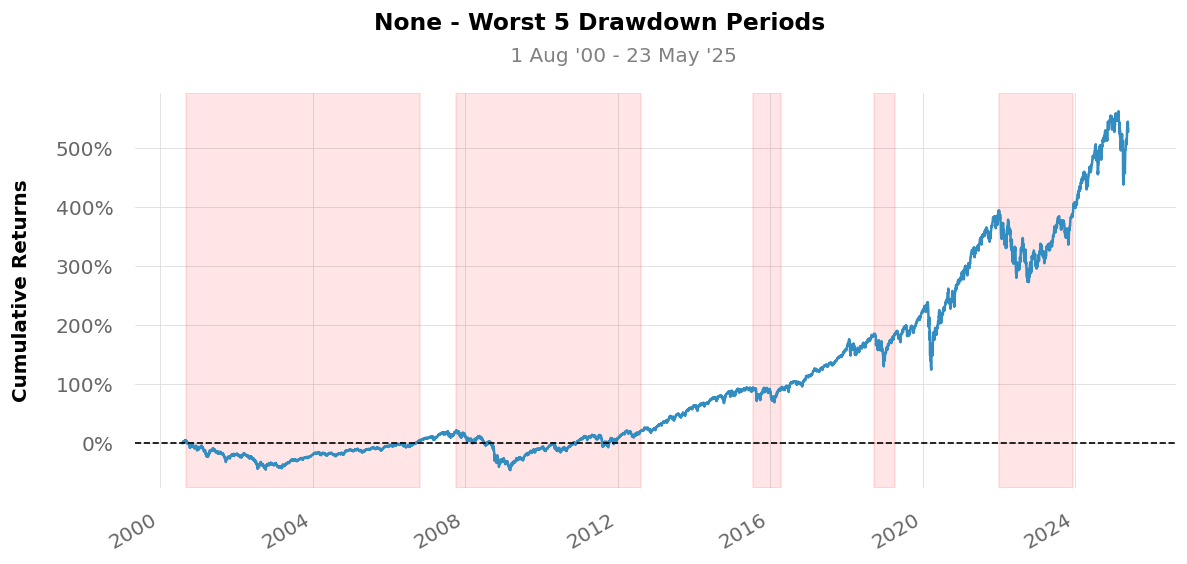

In [ ]:
qs.plots.drawdowns_periods(benchmark.pct_change())

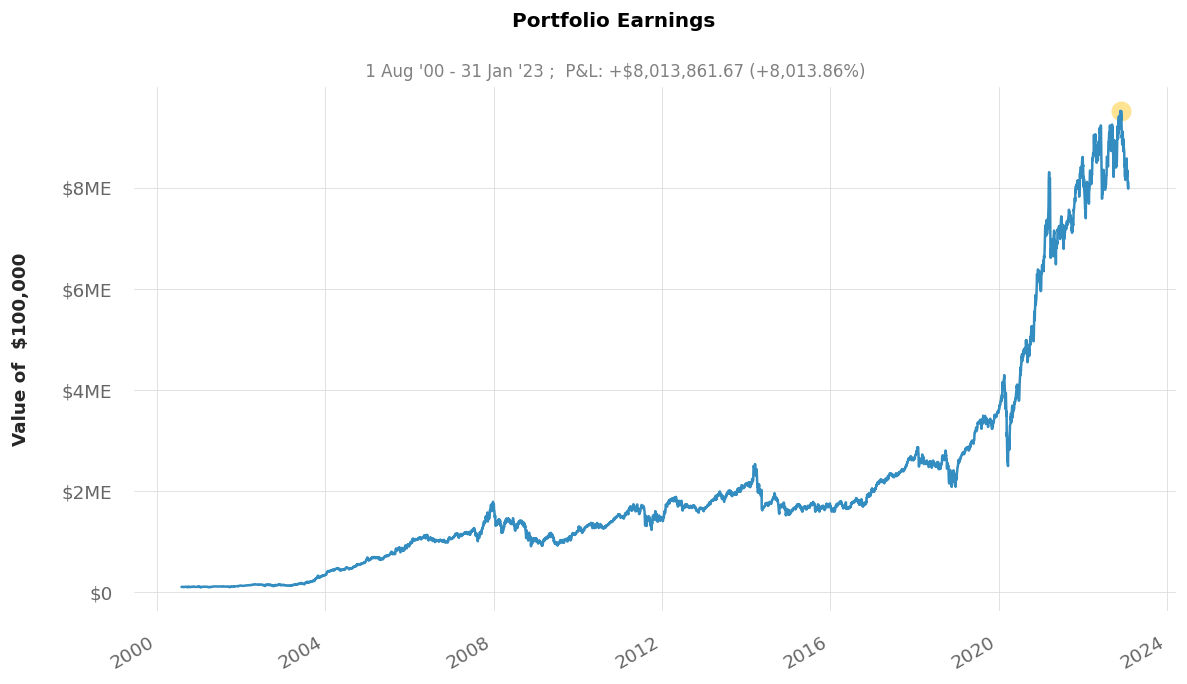

In [ ]:
qs.plots.earnings(estrategia)

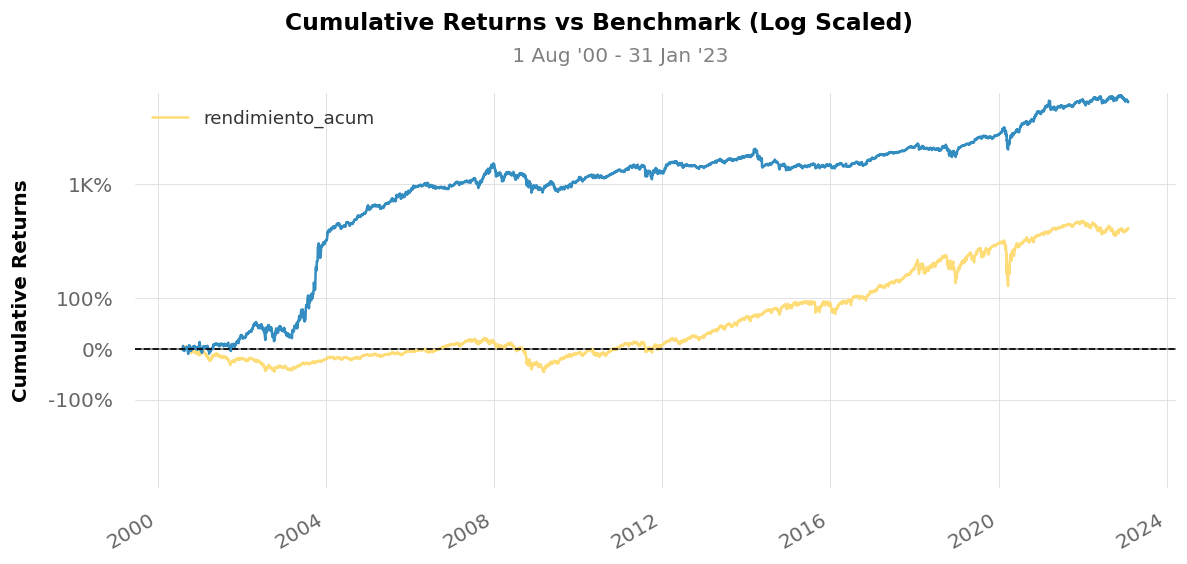

In [ ]:
qs.plots.log_returns(estrategia, benchmark.pct_change())

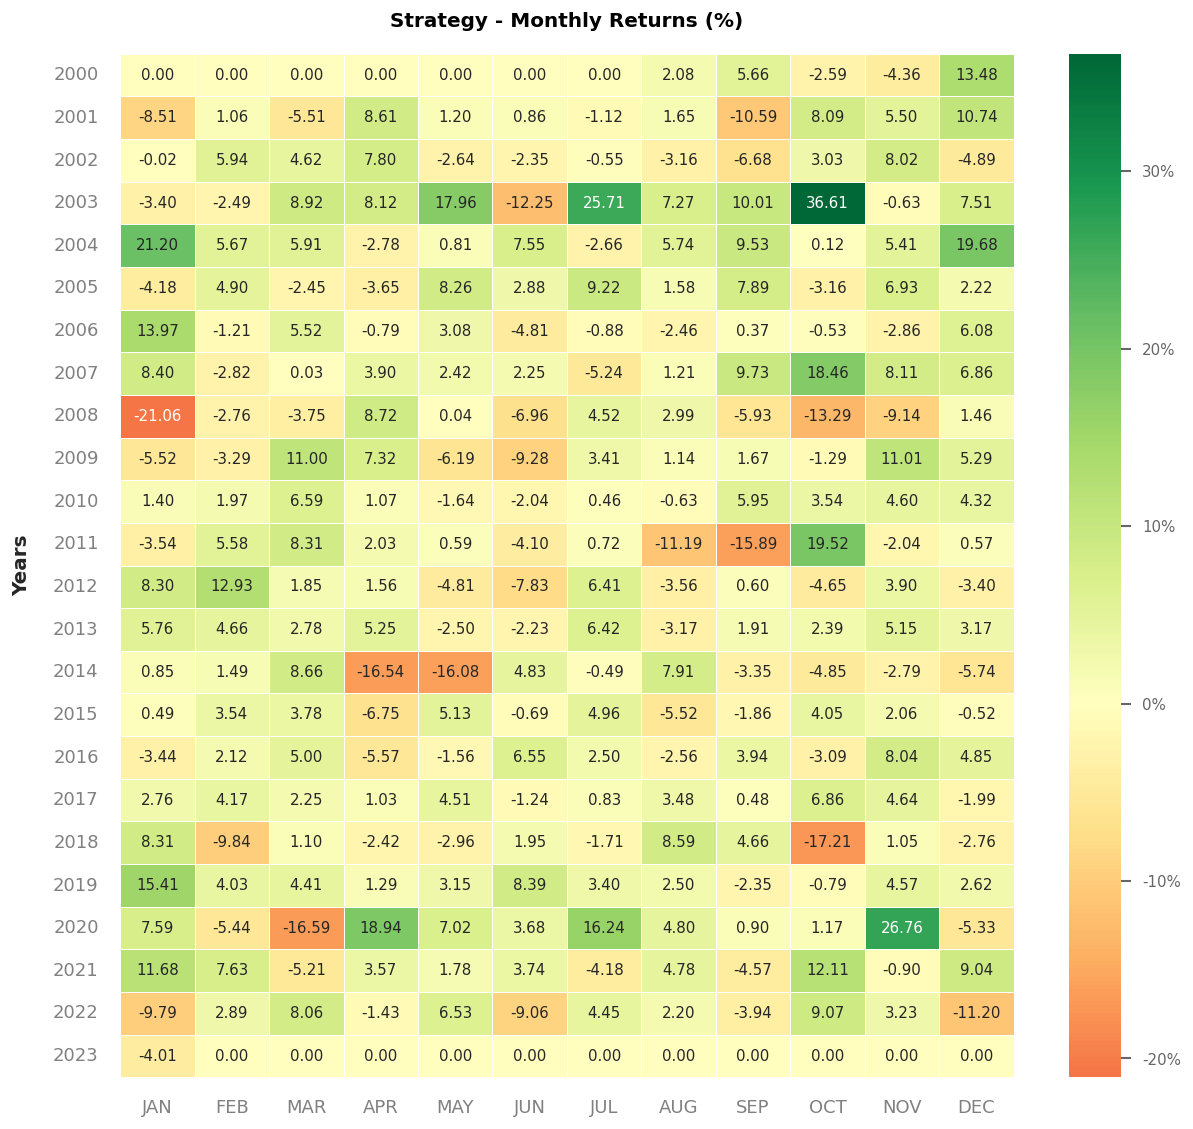

In [ ]:
qs.plots.monthly_returns(estrategia, eoy=False)

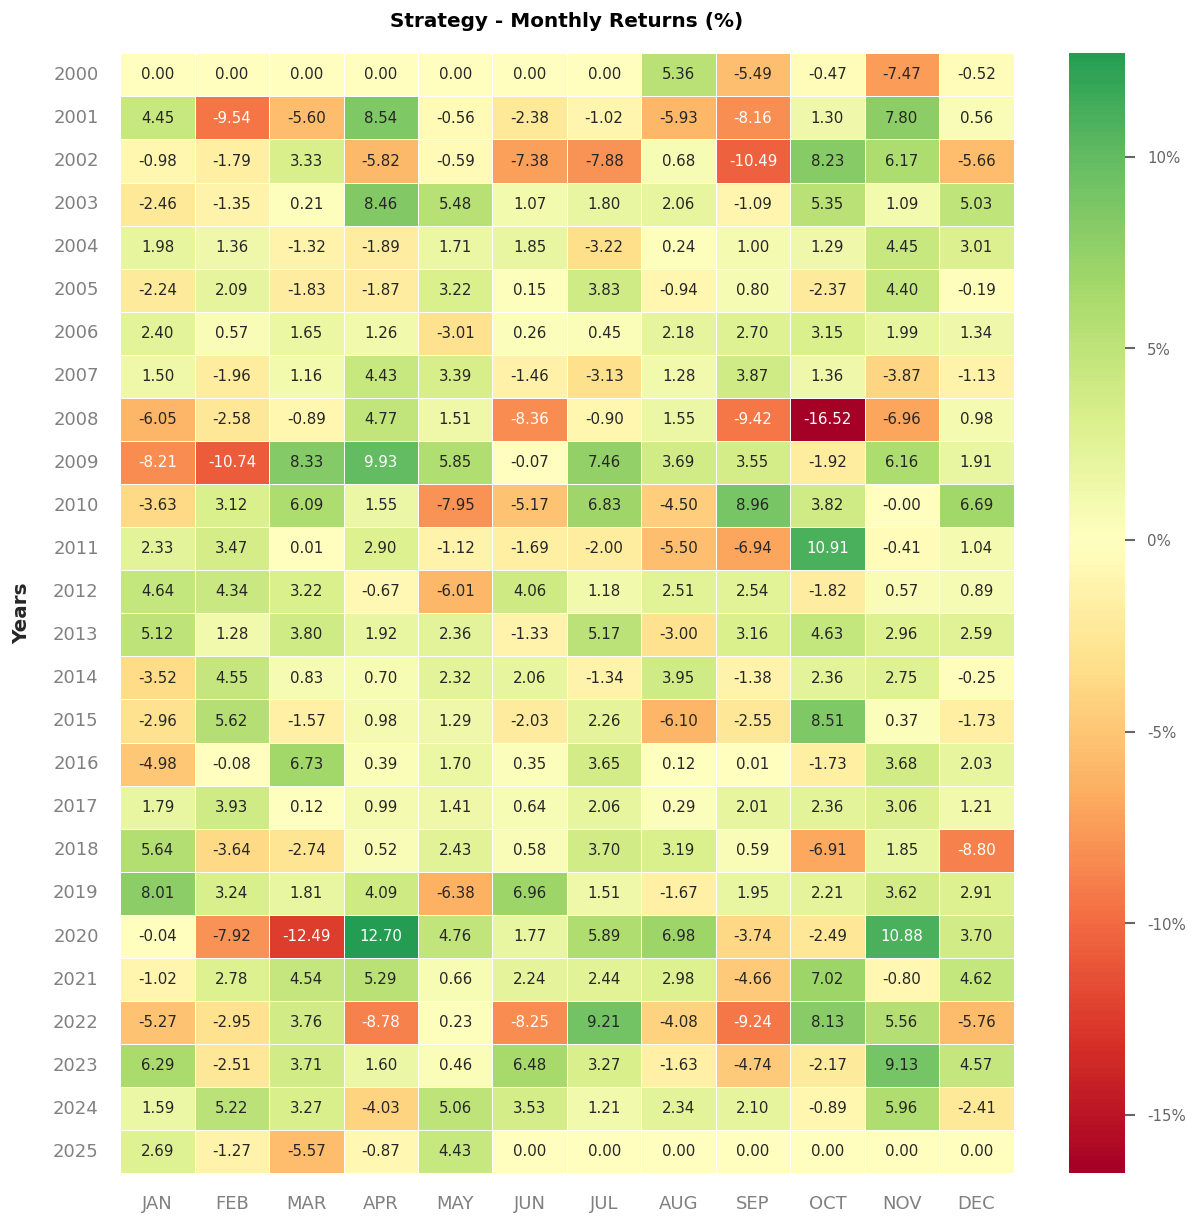

In [ ]:
qs.plots.monthly_returns(benchmark.pct_change(), eoy=False)

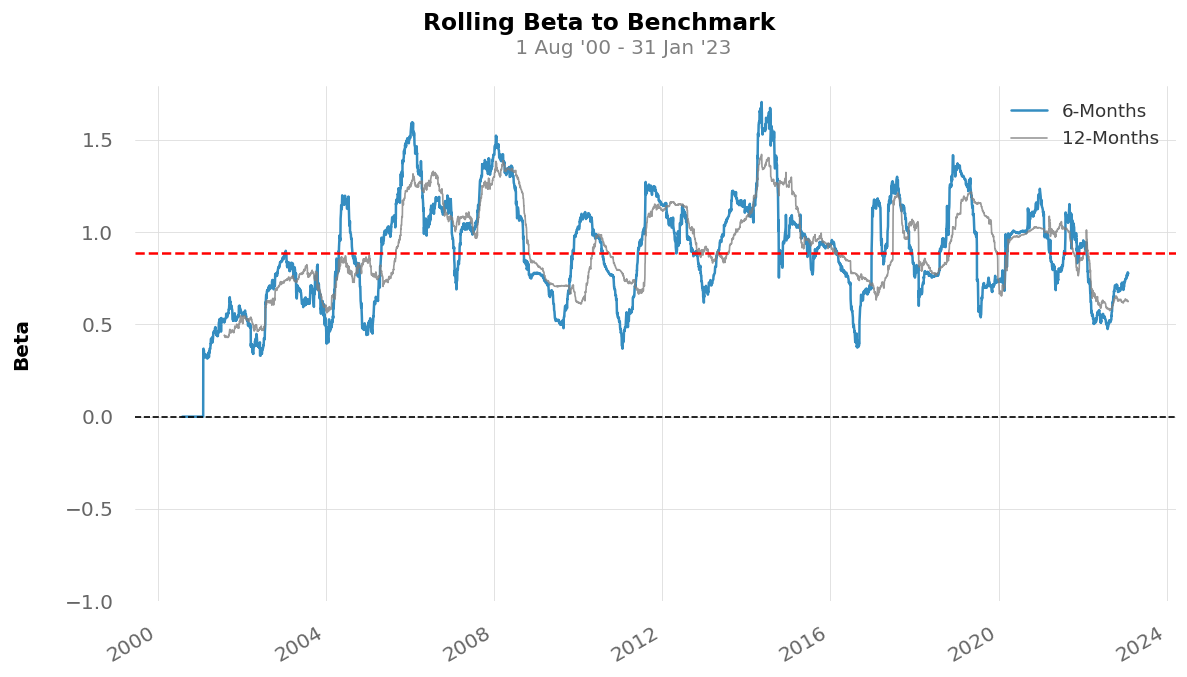

In [ ]:
qs.plots.rolling_beta(estrategia, benchmark.pct_change(), figsize=(10,6))

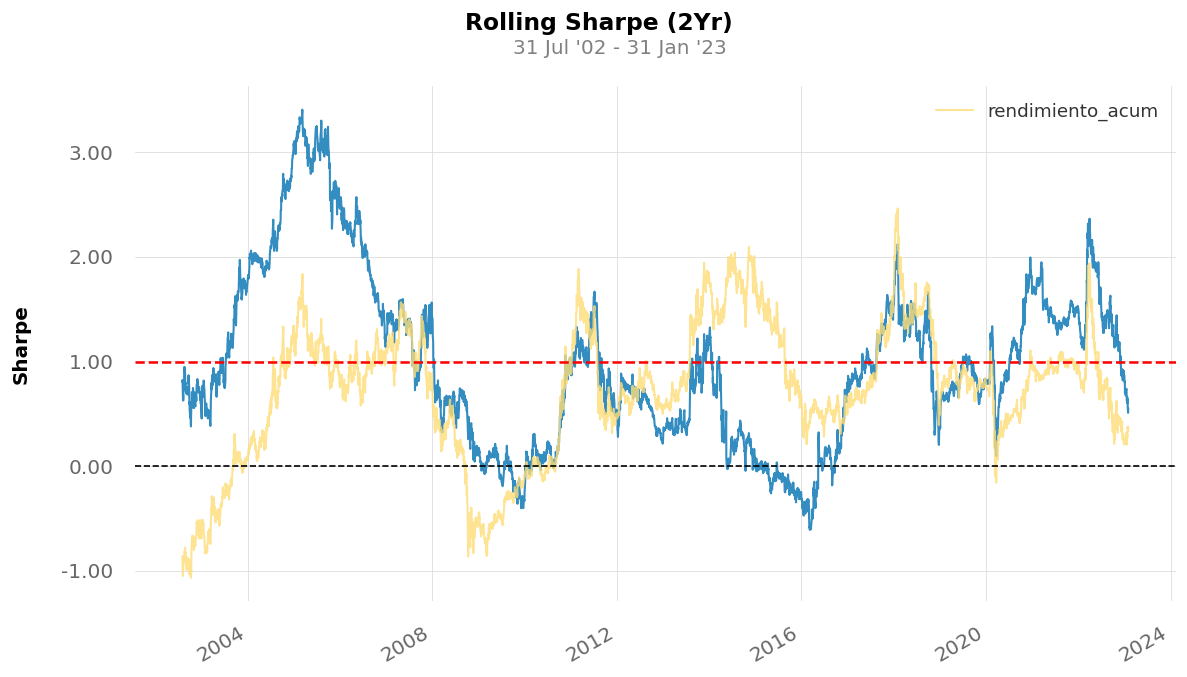

In [ ]:
qs.plots.rolling_sharpe(estrategia, benchmark.pct_change(), figsize=(10,6), period=500, period_label='2Yr')

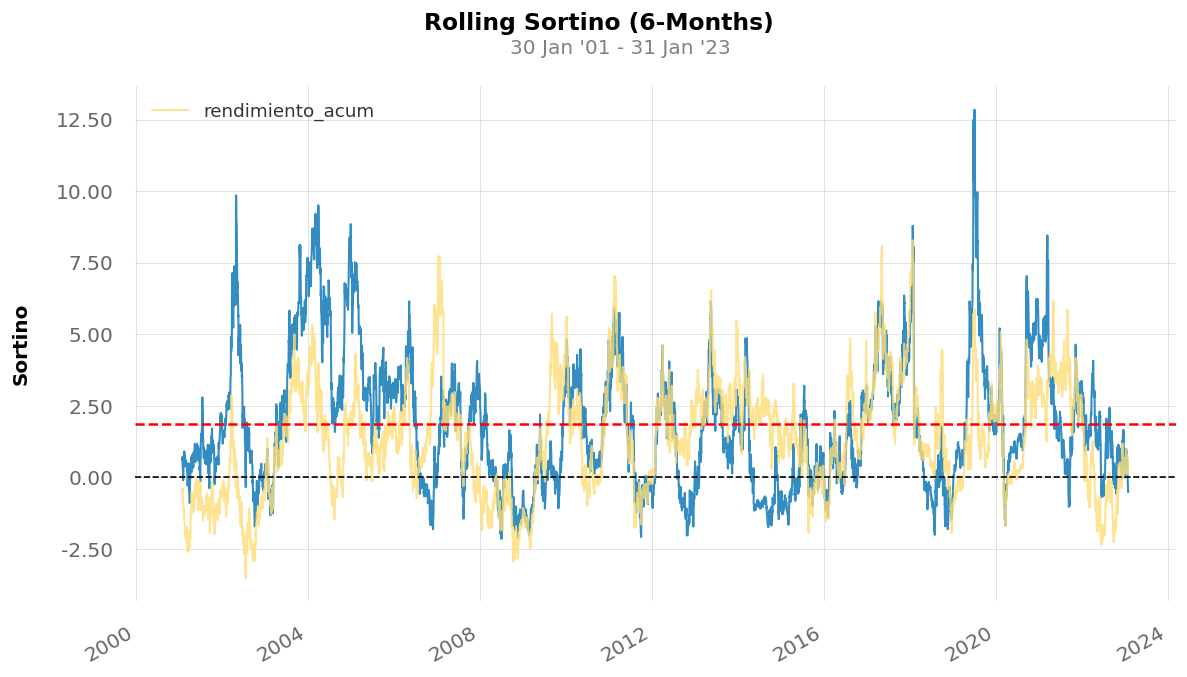

In [ ]:
qs.plots.rolling_sortino(estrategia, benchmark.pct_change(), figsize=(10,6))

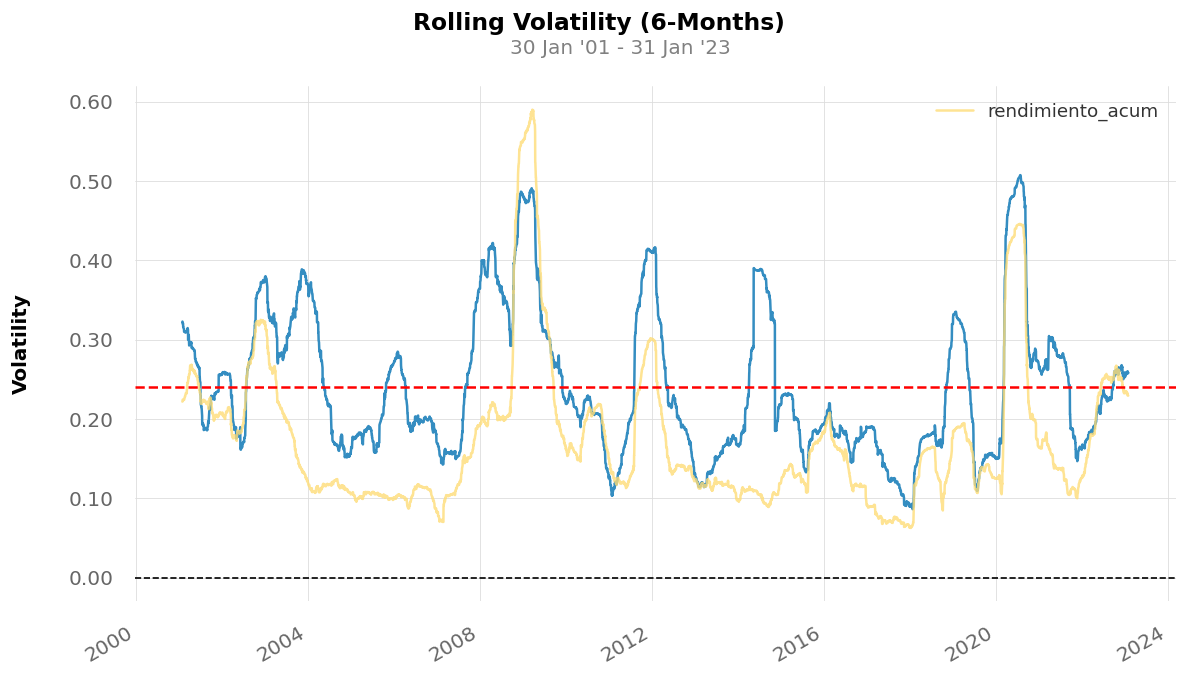

In [ ]:
qs.plots.rolling_volatility(estrategia, benchmark.pct_change(), figsize=(10,6))

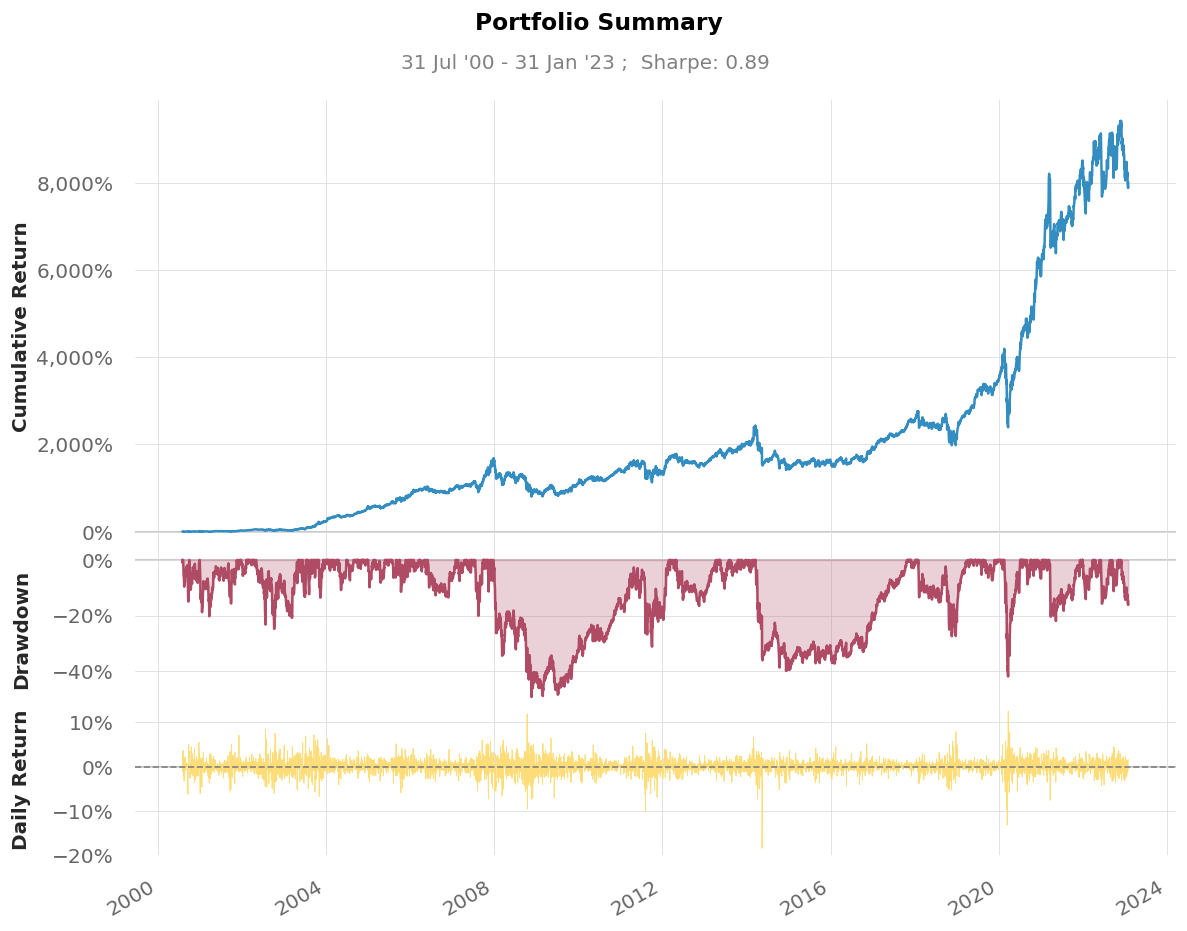

In [ ]:
qs.plots.snapshot(estrategia)

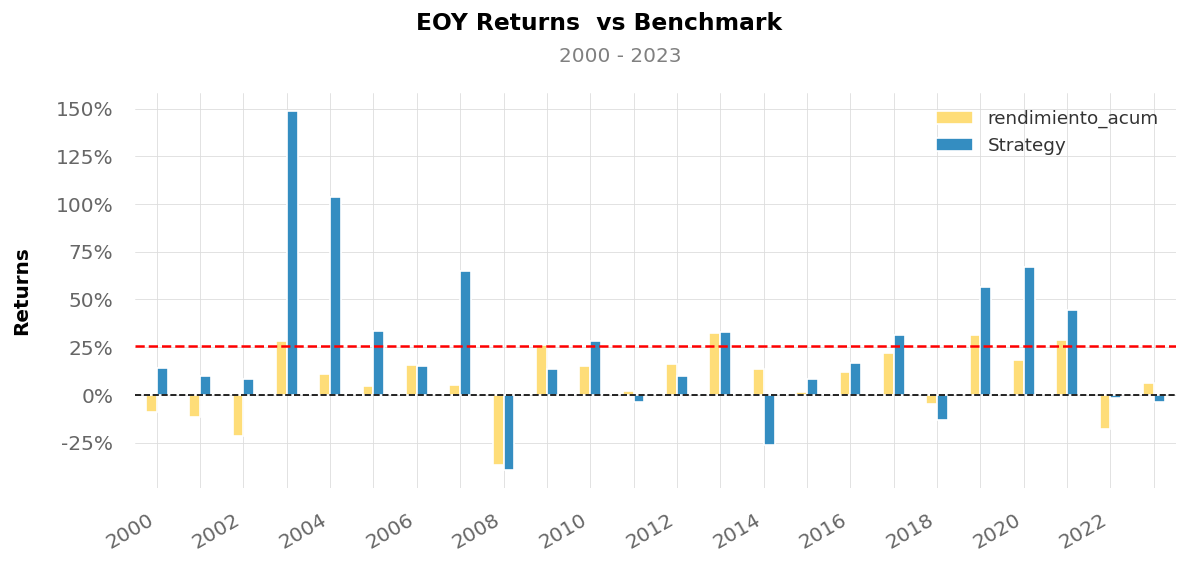

In [ ]:
qs.plots.yearly_returns(estrategia, benchmark.pct_change())

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

cmap_jp = LinearSegmentedColormap.from_list('Custom', ('red','white','green'), N=256)

pd.options.display.max_columns=13
qs.stats.monthly_returns(estrategia-benchmark.pct_change()).style.background_gradient(cmap=cmap_jp).format("{:.1%}")

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,EOY
2000,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,-0.5%,8.0%,-5.0%,-1.9%,14.4%,14.5%
2001,-9.5%,2.4%,-8.2%,9.1%,1.4%,1.0%,-1.2%,1.4%,-11.9%,10.8%,5.8%,11.3%,9.4%
2002,-2.1%,7.3%,4.3%,7.1%,-2.2%,-1.9%,-1.1%,-2.7%,-6.1%,2.9%,7.4%,-5.2%,6.7%
2003,-4.7%,-1.5%,11.3%,6.5%,16.7%,-11.4%,25.5%,7.0%,10.8%,36.1%,-0.7%,7.5%,148.8%
2004,21.2%,5.7%,5.9%,-2.6%,0.6%,7.4%,-2.6%,5.7%,9.7%,0.1%,5.4%,19.7%,103.7%
2005,-4.3%,5.1%,-2.5%,-3.9%,8.6%,2.9%,9.2%,1.3%,8.0%,-3.2%,7.0%,2.2%,33.4%
2006,14.0%,-1.2%,5.4%,-0.8%,3.0%,-4.7%,-0.9%,-2.5%,0.4%,-0.5%,-2.9%,6.1%,15.0%
2007,8.3%,-2.9%,0.1%,4.0%,2.4%,2.2%,-5.1%,1.0%,9.9%,18.3%,8.1%,7.0%,65.1%
2008,-21.2%,-2.5%,-3.9%,8.8%,-0.0%,-7.0%,4.7%,3.0%,-6.3%,-13.1%,-9.2%,1.4%,-39.6%
2009,-5.2%,-3.3%,10.6%,7.4%,-6.3%,-9.0%,3.3%,1.2%,1.6%,-1.0%,10.7%,5.4%,13.9%


In [ ]:
qs.stats.outliers(estrategia.pct_change()-benchmark.pct_change(), quantile=0.995)

,0
Date,
2000-09-25,0.057014
2001-10-01,0.052793
2001-12-05,0.053132
2002-10-24,0.042801
2003-03-31,0.048402
2003-06-12,0.051569
2003-07-08,0.064749
2003-07-10,0.044178
2003-09-17,0.073622
